In [8]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.cluster import KMeans
import umap

In [2]:
%matplotlib notebook
%widescreen

# Gather/organize data

## load the results summary for a single GLM version from mongo

In [3]:
rs = gat.retrieve_results(search_dict = {'glm_version': '4_L2_optimize_by_cell'}, results_type='summary')
rs.sample(10)

_id  index         dropout  variance_explained  \
1256869  5f246137a002203a68a49e10      8          change            0.249926   
1234889  5f2460f5d818d6e633e57907      9            hits            0.051472   
327385   5f22293fa9e6b8dd6c52ed5d     25      model_bias            0.060285   
429528   5f222ab03531e747f59d3ce5     24          image7            0.246370   
368771   5f2229eadcd48a84aab1c27c      1       intercept            0.258278   
1343877  5f2461b9e41fd514cbba9fd1      5  pre_lick_bouts            0.208302   
440189   5f222acf8eb51ba85f0075ea     29      all-images            0.006297   
1095243  5f245f480bb626e135827ad4     10          misses            0.047185   
528866   5f222c33e327749d36beb042     28  model_timing1D            0.134659   
609487   5f222e5bcd1110e7ac8d5747     15         running            0.041937   

         fraction_change_from_full  absolute_change_from_full  \
1256869                   0.000042                   0.000011   
1234889                   0.006392                   0.000327   
327385                   -0.000688                  -0.000041   
429528                   -0.001567                  -0.000387   
368771                    0.002032                   0.000524   
1343877                  -0.013603                  -0.002873   
440189                   -0.306670                  -0.002785   
1095243                   0.006529                   0.000306   
528866                    0.017954                   0.002375   
609487                    0.030185                   0.001229   

         cell_specimen_id  ophys_experiment_id  ophys_session_id  \
1256869         962618615            795948257         795866393   
1234889         961906142            822024770         821471625   
327385         1028804564            905955213         904771513   
429528          982831314            977978321         977760370   
368771         1017154311            866518316         866197765   
1343877         961998667            846487947         845840207   
440189         1017234538            992084626         991958444   
1095243        1007050806            956820482         956121729   
528866         1028815308            853363751         852794141   
609487         1028817106            974358973         973701907   

         behavior_session_id  container_id              project_code  \
1256869            795903435     814796558            VisualBehavior   
1234889            821521826     803516615            VisualBehavior   
327385             904922800    1018027663  VisualBehaviorMultiscope   
429528             977870164    1018028199  VisualBehaviorMultiscope   
368771             866336764    1018028426  VisualBehaviorMultiscope   
1343877            846011320     876693136            VisualBehavior   
440189             991992557    1018027775  VisualBehaviorMultiscope   
1095243            956269097     939523510            VisualBehavior   
528866             852974537    1018028150  VisualBehaviorMultiscope   
609487             973744975    1018027828  VisualBehaviorMultiscope   

        container_workflow_state experiment_workflow_state  \
1256869             container_qc                    passed   
1234889             container_qc                    passed   
327385                 completed                    passed   
429528                   holding                    passed   
368771                 completed                    passed   
1343877             container_qc                    passed   
440189                 completed                    passed   
1095243             container_qc                    passed   
528866                 completed                    passed   
609487                 completed                    passed   

                           session_name      session_type equipment_name  \
1256869  20181214_416369_2P5_VISp_375_3  OPHYS_3_images_A        CAM2P.5   
1234889        20190212_423606_1imagesA  OPHYS_1_images_

## get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [4]:
cols_for_clustering = list(rs['dropout'].unique())
cols_for_clustering.remove('visual')
cols_for_clustering

['Full',
 'intercept',
 'time',
 'pre_licks',
 'post_licks',
 'pre_lick_bouts',
 'post_lick_bouts',
 'rewards',
 'change',
 'hits',
 'misses',
 'false_alarms',
 'correct_rejects',
 'omissions',
 'image_expectation',
 'running',
 'pupil',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'model_bias',
 'model_task0',
 'model_omissions1',
 'model_timing1D',
 'all-images',
 'beh_model']

## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [5]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='fraction_change_from_full')

## add a `session_id` column with a numeric value for the session_type (to lump together sessions by order, regardless of image set)

In [10]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    return session_id
rsp['session_id'] = rsp['session_type'].map(lambda st:map_session_types(st))

rsp

identifier  Full  all-images  beh_model    change  \
0      1000743008_1003146172   0.0   -0.140223  -0.001848  0.000581   
1      1000743008_1003146180   0.0   -0.155019   0.004636  0.000530   
2      1000743008_1003146183   0.0   -0.210215   0.062499  0.000224   
3      1000743008_1003146186   0.0   -0.368535   0.021722  0.000232   
4      1000743008_1003146190   0.0   -0.089674   0.000823  0.000713   
...                      ...   ...         ...        ...       ...   
26790    995439942_994309997   0.0   -0.673633   0.086221  0.006062   
26791    995439942_994310000   0.0   -0.485011   0.007001  0.004174   
26792    995439942_994310003   0.0   -1.118526   0.042506  0.000775   
26793    995439942_994310018   0.0   -0.541743   0.006398  0.003886   
26794    995439942_994310024   0.0   -0.277435   0.013547  0.000625   

       correct_rejects  false_alarms      hits    image0    image1    image2  \
0             0.014875      0.008197  0.005280 -0.000634  0.003108  0.002692   
1             0.020636      0.011811  0.003584  0.002961  0.003979 -0.007203   
2             0.002435      0.001871  0.001834  0.001881  0.002758 -0.015761   
3             0.002308      0.006869  0.002990 -0.001212 -0.003161  0.000206   
4             0.027508      0.019429  0.006967  0.006088  0.004045 -0.003198   
...                ...           ...       ...       ...       ...       ...   
26790         0.071843      0.050225  0.058348 -0.005161  0.010604  0.016987   
26791         0.067006      0.025908  0.024597  0.014368  0.014290 -0.012931   
26792         0.003791      0.001357  0.004339  0.000590 -0.000652 -0.001458   
26793         0.040050      0.036957  0.039209  0.019981 -0.008514  0.007828   
26794         0.005525      0.004325  0.005053  0.000903  0.003351 -0.001719   

         image3    image4    image5    image6    image7  image_expectation  \
0      0.001819  0.003621 -0.001186 -0.026248  0.002645           0.000947   
1     -0.007210  0.002283 -0.018611  0.002152  0.002657           0.000976   
2      0.000383  0.000302 -0.012279  0.008475  0.001058          -0.001232   
3     -0.049498  0.001615 -0.021775  0.000046  0.002221          -0.003134   
4     -0.024926  0.003739  0.002454 -0.000550  0.008610           0.001467   
...         ...       ...       ...       ...       ...                ...   
26790  0.005398  0.010657  0.016359 -0.052912 -0.017866           0.012319   
26791  0.007199  0.001583  0.006884 -0.065082  0.001343           0.007638   
26792 -0.001410 -0.000970 -0.000321 -0.008589 -0.000520          -0.000430   
26793  0.020179 -0.061918  0.016950  0.010580  0.016852           0.011578   
26794  0.001421 -0.030594  0.001062  0.001363 -0.003418          -0.000713   

       intercept    misses  model_bias  model_omissions1  model_task0  \
0       0.000913 -0.001280   -0.001924          0.000501    -0.000538   
1       0.000081  0.006030    0.000728          0.001277     0.000856   
2      -0.002156  0.000572    0.010619          0.029392    -0.001927   
3       0.003374  0.002284    0.014580          0.006673     0.005393   
4       0.000038  0.000181   -0.000054          0.001188     0.000657   
...          ...       ...         ...               ...          ...   
26790  -0.013133  0.032441   -0.187010         -0.042443     0.019241   
26791  -0.000912  0.030111    0.004711         -0.006249     0.001660   
26792  -0.006349  0.001093    0.000506         -0.102949    -0.001359   
26793  -0.000300  0.020430    0.004984         -0.013852    -0.001372   
26794  -0.001291  0.003148    0.004363          0.003764     0.001219   

       model_timing1D  omissions  post_lick_bouts  post_licks  pre_lick_bouts  \
0            0.000135   0.008544         0.007587   -0.005937        0.011424   
1            0.002049   0.020436         0.001011    0.003103        0.031004   
2            0.021750  -0.000316        -0.004966    0.002149        0.003036   
3           -0.001058   0.002760        -0.001018    0.000574     

## Turn some categorical columns into numerical columns

In [47]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id']:
    make_categorical(rsp, column)


# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## UMAP

In [11]:
reducer_2d = umap.UMAP(n_components=2)
reducer_3d = umap.UMAP(n_components=3)


embedding_2d = reducer_2d.fit_transform(rsp[cols_for_clustering])
embedding_3d = reducer_3d.fit_transform(rsp[cols_for_clustering])

# add umap embeddings to datafr
rsp['umap_3d_embedding_0'] = embedding_3d[:, 0]
rsp['umap_3d_embedding_1'] = embedding_3d[:, 1]
rsp['umap_3d_embedding_2'] = embedding_3d[:, 2]

rsp['umap_2d_embedding_0'] = embedding_2d[:, 0]
rsp['umap_2d_embedding_1'] = embedding_2d[:, 1]

/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## k-means clustering on 3d umap

In [14]:

kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['k_means_on_3d_umap'] = kmeans.fit_predict(rsp[umap_cols])
rsp['k_means_on_3d_umap'].value_counts()

12    1855
1     1825
17    1700
15    1663
4     1618
8     1586
3     1504
9     1473
13    1343
16    1338
14    1323
0     1308
6     1297
2     1285
18    1238
5     1029
19    1000
7      985
10     733
11     692
Name: k_means_on_3d_umap, dtype: int64

## visualize in 2d using matplotlib

<IPython.core.display.Javascript object>


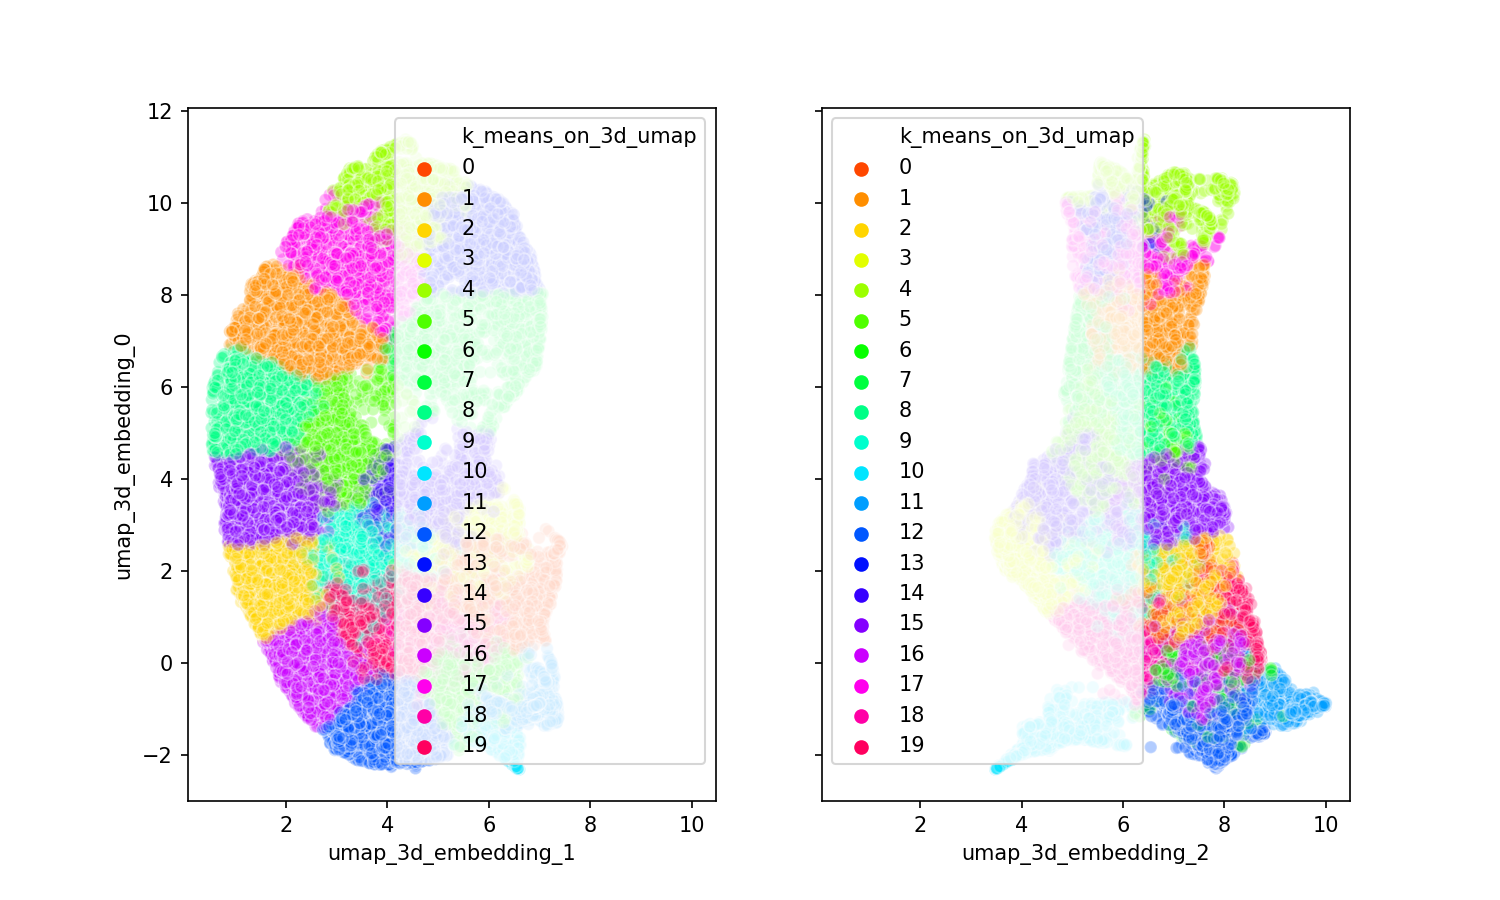

In [16]:
fig,ax=plt.subplots(1,2,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_3d_embedding_1', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hsv", len(rsp['k_means_on_3d_umap'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[0],
)
sns.scatterplot(
    x='umap_3d_embedding_2', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hsv", len(rsp['k_means_on_3d_umap'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[1],
)

## visualize in 3d using plotly

In [93]:
fig = px.scatter_3d(
    rsp, 
    x='umap_3d_embedding_0', 
    y='umap_3d_embedding_1', 
    z='umap_3d_embedding_2',
    color='k_means_on_3d_umap',
    color_continuous_scale='hsv',
)

# optional view positioning parameters (I don't really understand these, just toying with them to get a view I like!)
camera = dict(
    up=dict(x=3, y=1.75, z=0.25),
    eye=dict(x=1.5, y=1.5, z=-0.2)
)

fig.update_layout(
    scene_camera=camera,
    margin=dict(l=30, r=30, t=10, b=10),
    width=1200,
    height=1000,
)
fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/2020.08.21_k_means_on_umap.html")
fig.show()

# A little bit of prep for plotting

## first define the dominant dropout in each cluster

In [53]:
# identify dominant dropouts for each cluster
gat.identify_dominant_dropouts(rsp, cluster_column_name='k_means_on_3d_umap', cols_to_search=cols_for_clustering)

## define heatmap parameters
lots here, but there are lots of options!

In [94]:
cols_to_plot = [
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'session_id_categorical', 
    'k_means_on_3d_umap', 
    'equipment_name_categorical',
    'targeted_structure_categorical',
    'imaging_depth'
]

# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
heatmap_defs = [
    {
        'columns':sorted_cols,
        'cbar_label':'fraction change\nin var explained',
        'cbar_ticks':[-1,0,1],
        'vmin':-1,
        'vmax':1,
        'cmap':'bwr',
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(rsp['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },
    {
        'columns':['session_id_categorical'],
        'cbar_label':'session ID',
        'cbar_ticks':[0,1,2,3],
        'cbar_ticklabels':[1,3,4,6],
        'vmin':-0.5,
        'vmax':3.5,
        'cmap':sns.color_palette("Dark2", 4),
    },
    {
        'columns':['k_means_on_3d_umap'],
        'cbar_label':'k-means label',
        'cbar_ticks':np.arange(0,20,2),
        'vmin':0,
        'vmax':19,
        'cmap':sns.color_palette("hsv", 20),
    },
    {
        'columns':['equipment_name_categorical'],
        'cbar_label':'equipment name',
        'cbar_ticks':np.arange(len(rsp['equipment_name_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['equipment_name'])),
        'vmin':-0.5,
        'vmax':len(rsp['equipment_name_categorical'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['equipment_name_categorical'].unique())),
    },
    {
        'columns':['targeted_structure_categorical'],
        'cbar_label':'targeted structure',
        'cbar_ticks':np.arange(len(rsp['targeted_structure_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['targeted_structure'])),
        'vmin':-0.5,
        'vmax':len(rsp['targeted_structure'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['targeted_structure'].unique())),
    },
    {
        'columns':['imaging_depth'],
        'cbar_label':'imaging_depth',
        'cbar_ticks':[0,100,200,300,400],
        'vmin':0,
        'vmax':400,
        'cmap':'magma',
    },
]

# Make heatmaps, sort by whatever we want
Note that it only makes sense to nest sorting values for categorical data. Any sorting value that follows a continuous variable will not have any effect.

## First sort by dominant dropout, the median value of the dominant dropout (for cases with multiple clusters sharing the same dominant dropout), then cre_line, session_id, imaging_depth

<IPython.core.display.Javascript object>


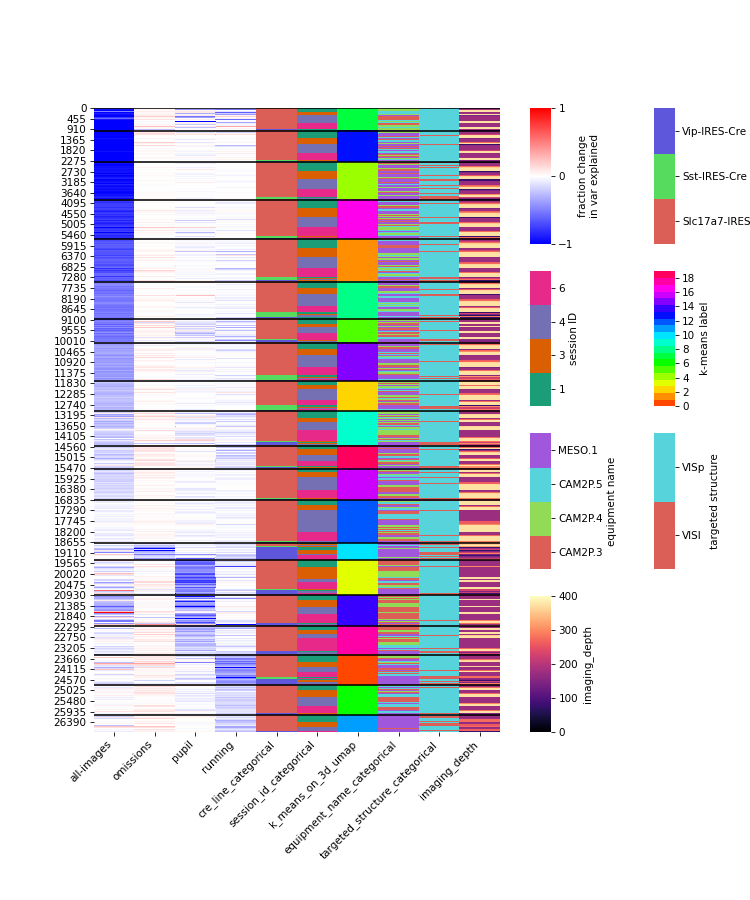

In [95]:
sort_order = ['dominant_dropout','dominant_dropout_median','cre_line_categorical','session_id_categorical','imaging_depth',]
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## another sorting, with imaging_depth being the emphasis

<IPython.core.display.Javascript object>


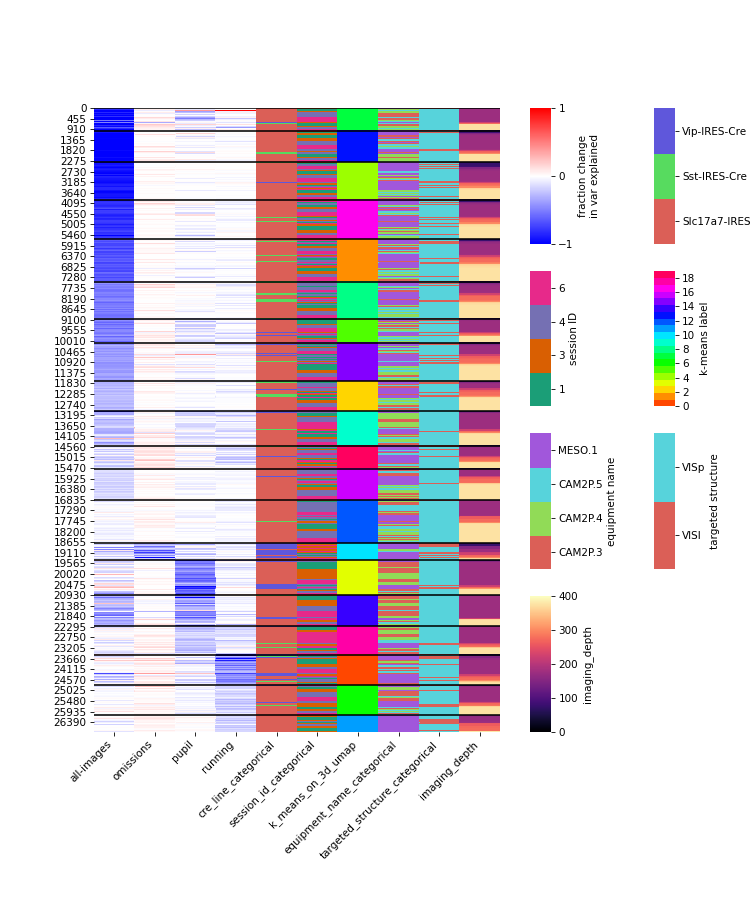

In [96]:
sort_order = ['dominant_dropout','dominant_dropout_median','imaging_depth','cre_line_categorical','session_id_categorical']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## and another sorting, with session_id being the emphasis

<IPython.core.display.Javascript object>


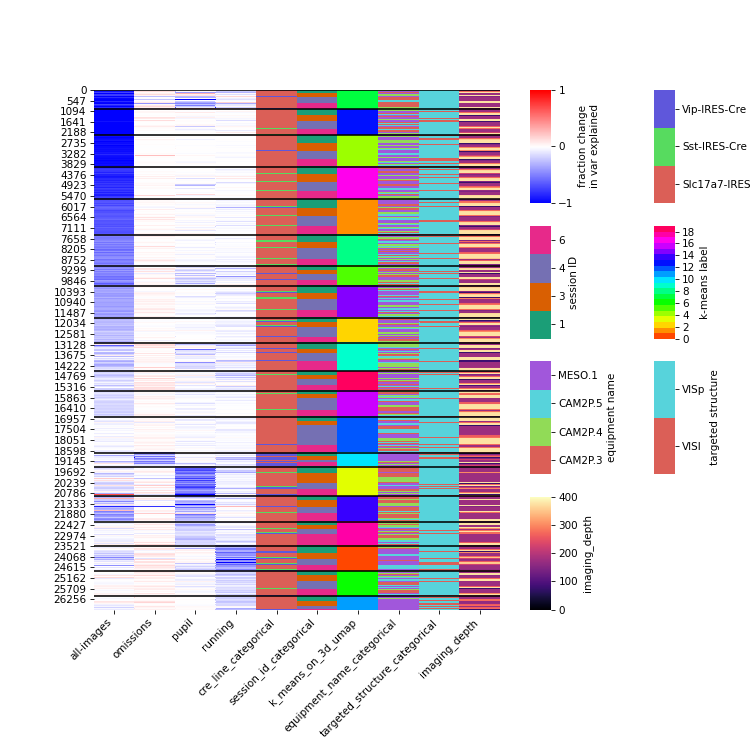

In [89]:
sort_order = ['dominant_dropout','dominant_dropout_median','session_id_categorical','cre_line_categorical','imaging_depth',]
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## sort by structure after dropout

<IPython.core.display.Javascript object>


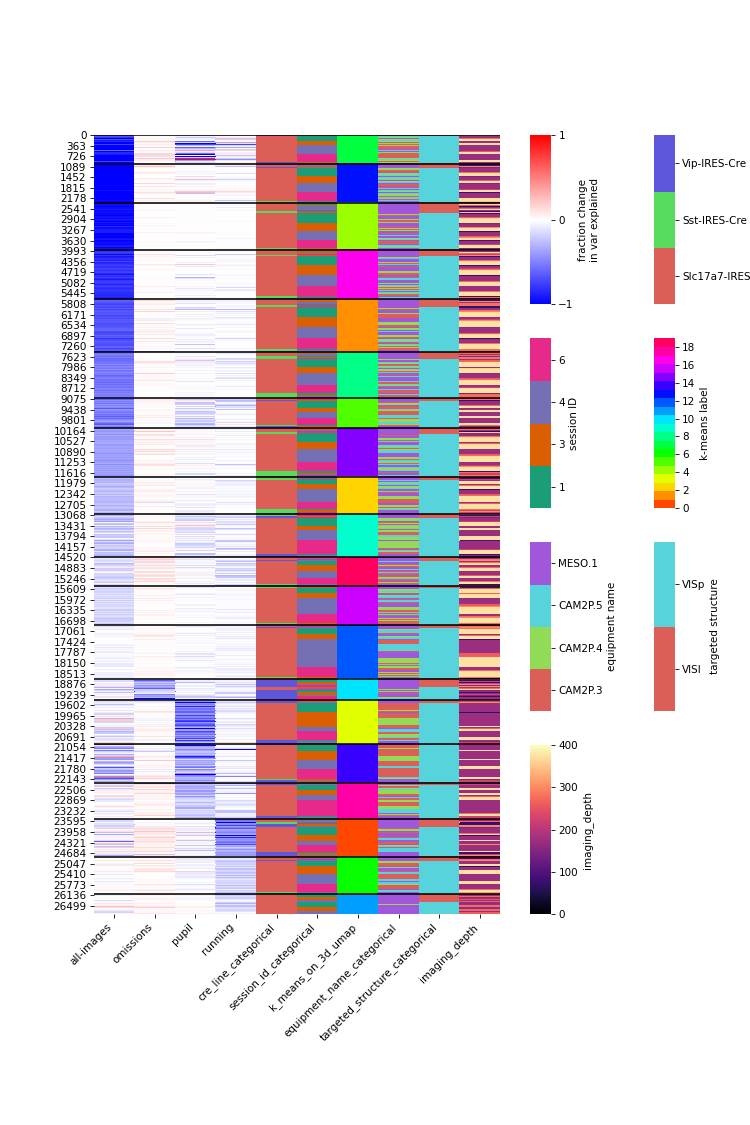

In [90]:
sort_order = ['dominant_dropout','dominant_dropout_median','targeted_structure_categorical','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,15), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## Sort by cluster ID and move it to the leftmost column

<IPython.core.display.Javascript object>


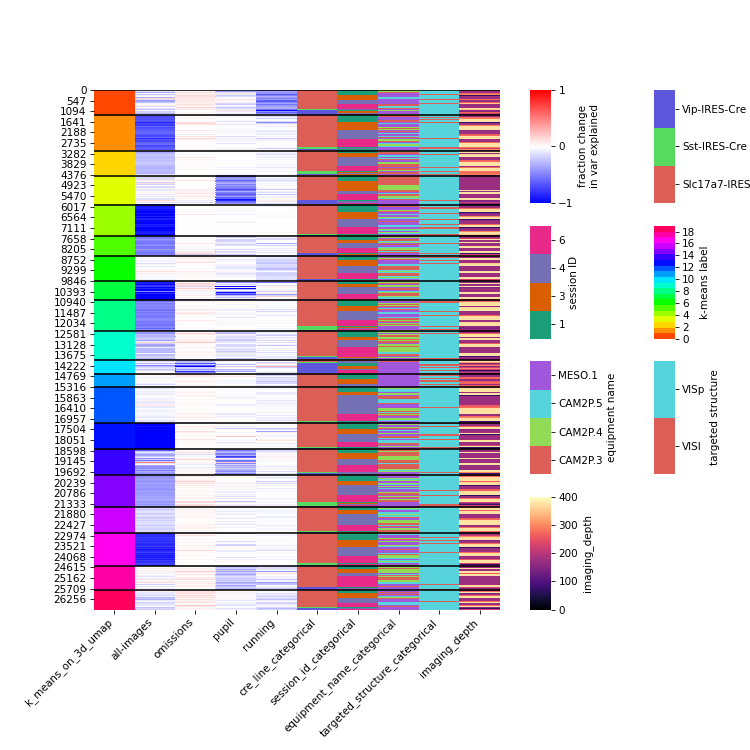

In [91]:
sort_order = ['k_means_on_3d_umap','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

cols_to_plot = [
    'k_means_on_3d_umap', 
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'session_id_categorical', 
    'equipment_name_categorical',
    'targeted_structure_categorical',
    'imaging_depth'
]

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')